In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore',category=UserWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria
from turbustat.statistics import PowerSpectrum
from astropy.io import fits
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
def adjust_spines(ax, spines,lw=None,movepos=None):
    ax.xaxis.set_tick_params(width=lw)
    ax.yaxis.set_tick_params(width=lw)
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', movepos))  # outward by 10 points
            spine.set_linewidth(lw)
        else:
            spine.set_color('none')  # don't draw spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])
        
def build_a_xarray_dataset(ds=None,varname=None,varfile=None):
    def build_xa(arraydata=None,arrayname=None):
        da = xr.DataArray(data=arraydata,dims=['samples','azimuth','radius','weight'],coords={'samples':np.linspace(0,350,351),'azimuth':np.linspace(0,359,360),\
                                                                                    'radius':np.linspace(0,166,167)*3,'weight':[0,1,2,3,4]},name=arrayname)
        return da
    # Complete the code
    for varobj,varnamen in zip(varfile,varname):
        da = build_xa(varobj.reshape(351,360,167,5),varnamen)
        ds = xr.merge( [ds , da ] )
    return ds

#### Read

In [3]:
procWEIGHTS = read_and_proc.depickle('./preproc/QRADNORAD_weights')

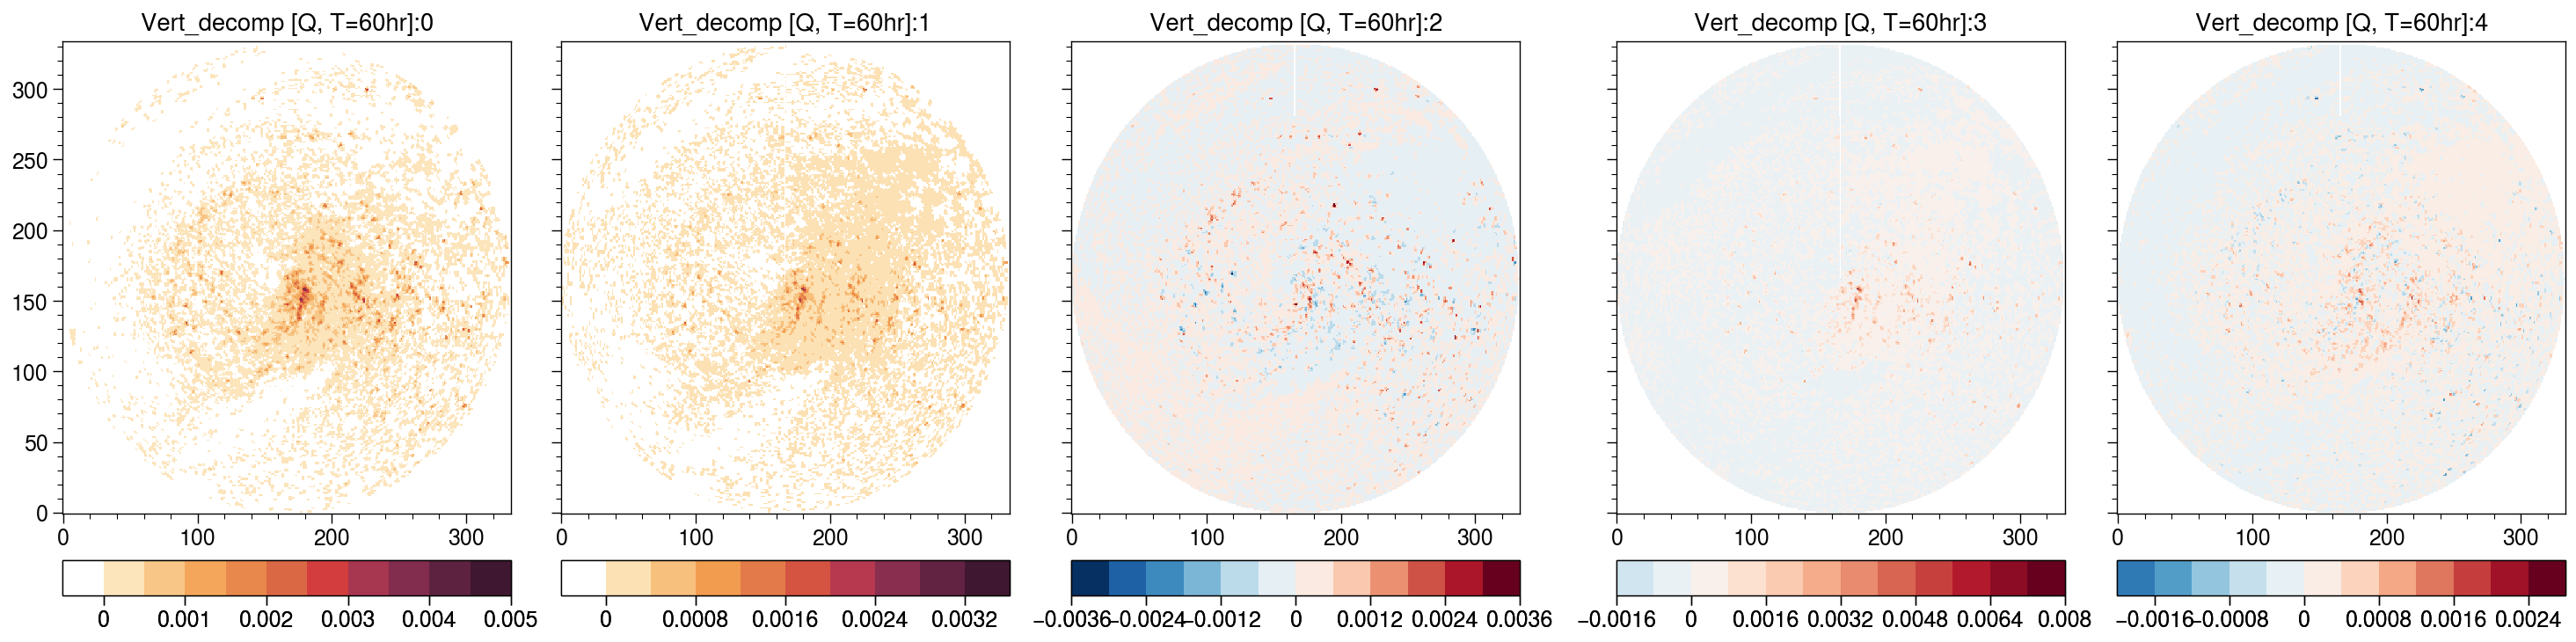

In [50]:
fig,axs = plot.subplots(ncols=5,nrows=1,axwidth=2.55,refaspect=0.951,sharey=3,sharex=0)
pax = axs[0].pcolormesh(np.ma.masked_equal(np.swapaxes(procWEIGHTS['Q'][60,:,:,0],0,1),0))
axs[0].colorbar(pax,loc='b')
pax = axs[1].pcolormesh(np.ma.masked_equal(np.swapaxes(procWEIGHTS['Q'][60,:,:,1],0,1),0))
axs[1].colorbar(pax,loc='b')
pax = axs[2].pcolormesh(np.ma.masked_equal(np.swapaxes(procWEIGHTS['Q'][60,:,:,2],0,1),0))
axs[2].colorbar(pax,loc='b')
pax = axs[3].pcolormesh(np.ma.masked_equal(np.swapaxes(procWEIGHTS['Q'][60,:,:,3],0,1),0))
axs[3].colorbar(pax,loc='b')
pax = axs[4].pcolormesh(np.ma.masked_equal(np.swapaxes(procWEIGHTS['Q'][60,:,:,4],0,1),0))
axs[4].colorbar(pax,loc='b')

for i in range(5):
    axs[i].format(title='Vert_decomp [Q, T=60hr]:'+str(i))
plt.savefig('./figures/0329/vert_decomp_Q60.png',dpi=300)
plt.show()

##### Spectral 

In [28]:
from scipy.fftpack import rfft, irfft, fftfreq
# assign some real spatial co-ordinates to the grid points   
# first define the edge values
x_min = -167.0*3
x_max = 167.0*3
y_min = -167.0*3
y_max = 167.0*3

# then create some empty 2d arrays to hold the individual cell values
x_array = np.zeros( (334,334) , dtype = float )
y_array = np.zeros( (334,334) , dtype = float )

# now fill the arrays with the associated values
for row , y_value in enumerate(np.linspace (y_min , y_max , num = 334) ):
    for column , x_value in enumerate(np.linspace (x_min , x_max , num = 334) ):
        x_array[row][column] = x_value
        y_array[row][column] = y_value

# now we can use fftfreq to give us a base for the wavenumber co-ords
# this returns [0.0 , 1.0 , 2.0 , ... , 62.0 , 63.0 , -64.0 , -63.0 , ... , -2.0 , -1.0 ]
n_value = fftfreq( 334 , (1.0 / 334.0 ) )

# now we can initialize some arrays to hold the wavenumber co-ordinates of each cell
kx_array = np.zeros( (334,334) , dtype = float )
ky_array = np.zeros( (334,334) , dtype = float )
x_length = x_max - x_min
y_length = y_max - y_min

# now the loops to calculate the wavenumbers
for row in range(334):
    for column in range(334):
        kx_array[row][column] = ( 2.0 * np.pi * n_value[column] ) / x_length
        ky_array[row][column] = ( 2.0 * np.pi * n_value[row] ) / y_length

In [17]:
filelistRAD,filelistNORAD = sorted(glob.glob('./output/storeRAD*')),sorted(glob.glob('./output/storeNORAD*'))
fileRAD,fileNORAD = [read_and_proc.depickle(filex) for filex in filelistRAD], [read_and_proc.depickle(filex) for filex in filelistNORAD]

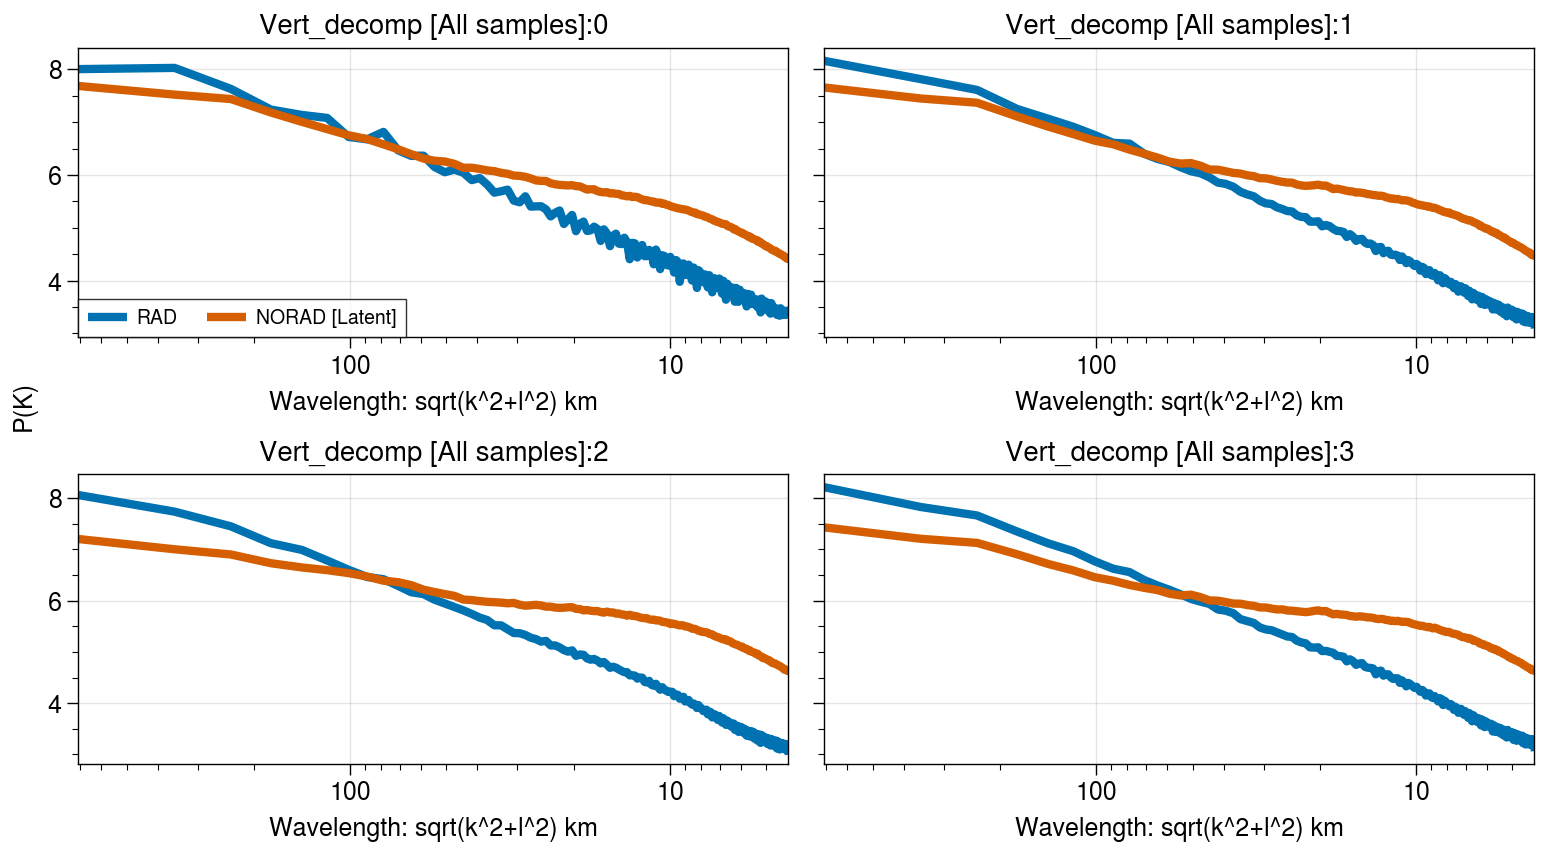

In [54]:
WV = np.sqrt(kx_array**2+kx_array**2)
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=3.55,refaspect=2.451,sharey=3,sharex=0)
axs[0].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileRAD[0]),axis=0))[0:167],label='RAD',lw=3)
axs[0].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileNORAD[0]),axis=0))[0:167],label='NORAD [Latent]',lw=3)
axs[0].set_xscale('log')
axs[0].legend(loc='ll',prop=dict(size=7))

axs[1].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileRAD[1]),axis=0))[0:167],lw=3)
axs[1].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileNORAD[1]),axis=0))[0:167],lw=3)
axs[1].set_xscale('log')

axs[2].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileRAD[2]),axis=0))[0:167],lw=3)
axs[2].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileNORAD[2]),axis=0))[0:167],lw=3)
axs[2].set_xscale('log')

axs[3].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileRAD[3]),axis=0))[0:167],lw=3)
axs[3].plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(fileNORAD[3]),axis=0))[0:167],lw=3)
axs[3].set_xscale('log')

for i in range(4):
    axs[i].format(title='Vert_decomp [All samples]:'+str(i),xlabel='Wavelength: sqrt(k^2+l^2) km',ylabel='P(K)')
plt.savefig('./figures/0329/powerspectrum_allsamples.png',dpi=350)
plt.show()

In [51]:
np.log10(np.std(np.asarray(fileRAD[0]),axis=0))[0:167]

array([8.02490089, 7.49552501, 7.44780312, 6.95420443, 6.64354295,
       6.4838494 , 6.41146589, 6.35284422, 5.90818165, 6.19167787,
       5.80135619, 5.8013643 , 5.54406927, 5.52937181, 5.54011009,
       5.33991307, 5.34581369, 5.31330083, 5.27636713, 5.0899844 ,
       5.10658028, 4.98866099, 4.96608637, 4.86357909, 4.77842145,
       4.84170276, 4.84396708, 4.73282556, 4.68653848, 4.63503463,
       4.66318566, 4.61119814, 4.63225105, 4.53460206, 4.52840325,
       4.50822281, 4.50656454, 4.49188536, 4.37896235, 4.38385781,
       4.40839106, 4.39758911, 4.30120986, 4.39837044, 4.26461175,
       4.21337272, 4.31706523, 4.21571029, 4.1967889 , 4.23432504,
       4.21453574, 4.09377124, 4.04949339, 4.15972984, 3.97845987,
       3.98557128, 4.08882853, 3.95734607, 3.91982899, 3.95831849,
       3.95911763, 3.85447621, 3.96830468, 3.92650326, 3.88889087,
       3.84847118, 3.88750912, 3.78810316, 3.7259625 , 3.69425118,
       3.79148645, 3.69551336, 3.65706178, 3.76700452, 3.65848